In [1]:
from histogram_functions import *
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from tqdm import tqdm
import math
import cmath
from scipy.integrate import simpson, romb
from scipy.stats import iqr, norm, gaussian_kde
from scipy.special import erfc, wofz
import pickle
import os

In [2]:
# parameters

mu = 0.8
nu = 1.2
alpha = 1 + 0.5 * 1j
kappa = 0.85 # noise level, kappa=1 means no noise

n_precision = 1000
L_limit = find_suitable_L(mu, nu, alpha)
X_precision = np.linspace(-L_limit,L_limit,n_precision)
true_pdf = normalized_cat_state_pdf(mu, nu, alpha, X_precision)

trial_times = 1
n = 500

hist_counts_per_time = []
W_Gaussian_per_time = []
W_Epanechnikov_per_time = []
MSE_Gaussian_per_time = []
MSE_Epanechnikov_per_time = []
bd_Gaussian_per_time = []
bd_Epanechnikov_per_time = []

for _ in tqdm(range(trial_times)):
    X_samples = samplings_with_noisy_pdf(true_pdf, X_precision, n, kappa)
    hist_counts, bin_edges = np.histogram(X_samples, bins=30, density=True)
    hist_counts_per_time.append(hist_counts)

    W_Gaussian, bw_Gaussian = pdf_kernel_optimal_bandwidth(X_precision, X_samples, kernel_method = 'gaussian', bandwidth_method = 'cv')
    MSE_Gaussian = simpson(y = (true_pdf - W_Gaussian)**2, x = X_precision)
    W_Gaussian_per_time.append(W_Gaussian)
    MSE_Gaussian_per_time.append(MSE_Gaussian)
    bd_Gaussian_per_time.append(bw_Gaussian)

    W_Epanechnikov, bw_Epanechnikov = pdf_kernel_optimal_bandwidth(X_precision, X_samples, kernel_method = 'epanechnikov', bandwidth_method = 'silverman')
    MSE_Epanechnikov = simpson(y = (true_pdf - W_Epanechnikov)**2, x = X_precision)
    W_Epanechnikov_per_time.append(W_Epanechnikov)
    MSE_Epanechnikov_per_time.append(MSE_Epanechnikov)
    bd_Epanechnikov_per_time.append(bw_Epanechnikov)

avg_W_Gaussian = np.mean(W_Gaussian_per_time, axis=0)
std_W_Gaussian = np.std(W_Gaussian_per_time, axis=0)

avg_W_Epanechnikov = np.mean(W_Epanechnikov_per_time, axis=0)
std_W_Epanechnikov = np.std(W_Epanechnikov_per_time, axis=0)

avg_hist_counts = np.mean(hist_counts_per_time, axis=0)
std_hist_counts = np.std(hist_counts_per_time, axis=0)

avg_MSE_Gaussian = np.mean(MSE_Gaussian_per_time)
std_MSE_Gaussian = np.std(MSE_Gaussian_per_time)

avg_MSE_Epanechnikov = np.mean(MSE_Epanechnikov_per_time)
std_MSE_Epanechnikov = np.std(MSE_Epanechnikov_per_time)

avg_bd_Gaussian = np.mean(bd_Gaussian_per_time)
std_bd_Gaussian = np.std(bd_Gaussian_per_time)

avg_bd_Epanechnikov = np.mean(bd_Epanechnikov_per_time)
std_bd_Epanechnikov = np.std(bd_Epanechnikov_per_time)


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


Average Mean Squared Error of Gaussian Kernel:  0.002261914405102537 +- 0.0
Average Mean Squared Error of Epanechnikov Kernel:  0.0067843792329944945 +- 0.0
Average Bandwidth of Gaussian Kernel:  0.3562247890262442 +- 0.0
Average Bandwidth of Epanechnikov Kernel:  0.2856831154244385 +- 0.0


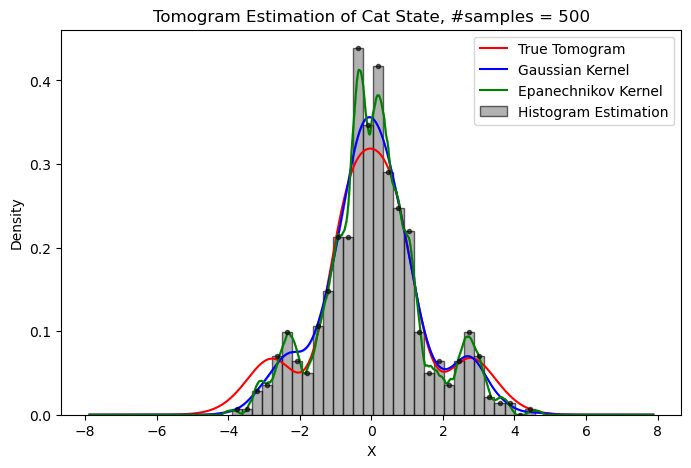

In [3]:
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])


# Plot mean histogram with error bars
plt.figure(figsize=(8, 5))
plt.bar(bin_centers, avg_hist_counts, width=(bin_edges[1] - bin_edges[0]), alpha=0.6, label="Histogram Estimation", color="gray", edgecolor="black")
plt.errorbar(bin_centers, avg_hist_counts, yerr=std_hist_counts, fmt='.', color="black", alpha = 0.6)

plt.plot(X_precision, true_pdf, color = 'red', label="True Tomogram")
plt.plot(X_precision, avg_W_Gaussian, color = 'blue', label="Gaussian Kernel")
plt.fill_between(X_precision, avg_W_Gaussian - std_W_Gaussian, avg_W_Gaussian + std_W_Gaussian, color = 'blue', alpha = 0.3)

plt.plot(X_precision, avg_W_Epanechnikov, color = 'green', label="Epanechnikov Kernel")
plt.fill_between(X_precision, avg_W_Epanechnikov - std_W_Epanechnikov, avg_W_Epanechnikov + std_W_Epanechnikov, color = 'green', alpha = 0.3)



plt.legend()
plt.xlabel("X")
plt.ylabel("Density")
plt.title("Tomogram Estimation of Cat State, #samples = {}".format(n))


print("Average Mean Squared Error of Gaussian Kernel: ", avg_MSE_Gaussian, "+-", std_MSE_Gaussian)
print("Average Mean Squared Error of Epanechnikov Kernel: ", avg_MSE_Epanechnikov, "+-", std_MSE_Epanechnikov)

print("Average Bandwidth of Gaussian Kernel: ", avg_bd_Gaussian, "+-", std_bd_Gaussian)
print("Average Bandwidth of Epanechnikov Kernel: ", avg_bd_Epanechnikov, "+-", std_bd_Epanechnikov)
